##### <font color=#A0A0A0>
##### ════════════════════════════════════════════════════════
#####     📊 **ANALYSIS AND CLASSIFICATION OF HUM AND SPAM MESSAGES**
##### ════════════════════════════════════════════════════════ </font>

In [4]:
#Import of used Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\konec\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\konec\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\konec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#Data loading
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['type', 'message'])

print(df.head())

   type                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


#### <font color=#A0A0A0>📈 **Exploratory Data Analysis**</font>

Let´s find the proportion of message which are ham and spam

In [6]:
df.groupby('type').count()

,message
type,
ham,4825
spam,747


Text(0.5, 0, 'Type')

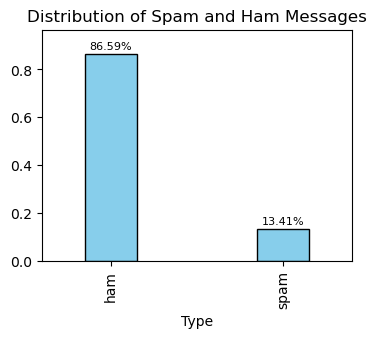

In [7]:
#Displaying message category distribution in a barplot 
plt.figure(figsize=(4, 3))
proportion = df['type'].value_counts(normalize=True)
bars = proportion.plot(kind='bar', width=0.3, color='skyblue', edgecolor='black')
plt.ylim(0, proportion.max() + 0.1)

for i, value in enumerate(proportion):
    bars.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom', fontsize=8)

plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Type')

In [8]:
# There's an umbalanced in the data, the ham messages are more common than spam.
# This is somenthing to take care at the moment of creating a model to predict future message predictions.

In [9]:
# Let's find for the most common messages by type or category.
df_ham_counts = df[df['type']=='ham'].groupby('message').aggregate(count=('message', 'size')).reset_index()
df_ham_counts = df_ham_counts.sort_values('count', ascending=False)
df_ham_counts.head(10)

,message,count
3327,"Sorry, I'll call later",30
1524,I cant pick the phone right now. Pls send a me...,12
2892,Ok...,10
62,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
2920,Okie,4
2795,Ok,4
2872,Ok.,4
3144,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",4
3906,"Wen ur lovable bcums angry wid u, dnt take it ...",4
4342,Your opinion about me? 1. Over 2. Jada 3. Kusr...,4


In [10]:
df_spam_counts = df[df['type']=='spam'].groupby('message').aggregate(count=('message', 'size')).reset_index()
df_spam_counts = df_spam_counts.sort_values('count', ascending=False)
df_spam_counts.head(10)

,message,count
337,Please call our customer service representativ...,4
160,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,3
284,"Loan for any purpose £500 - £75,000. Homeowner...",3
227,HMV BONUS SPECIAL 500 pounds of genuine HMV vo...,3
79,Camera - You are awarded a SiPix Digital Camer...,3
264,I don't know u and u don't know me. Send CHAT ...,3
13,18 days to Euro2004 kickoff! U will be kept in...,2
592,You have 1 new voicemail. Please call 08719181...,2
577,You are awarded a SiPix Digital Camera! call 0...,2
566,YOU ARE CHOSEN TO RECEIVE A £350 AWARD! Pls ca...,2


In [11]:
# The most commmon ham messages are replies to previous messages and calls
# Otherwise the spam messages are offers of prizes, bonuses or free stuff

In [12]:
# Now it'd be good to recognize patterns in the data like the length of the messages, with a general overview of the data 
# the spam messages seems to have a larger length.
df_message_length = df.copy()
df_message_length['length'] = df_message_length['message'].apply(lambda x: len(x))

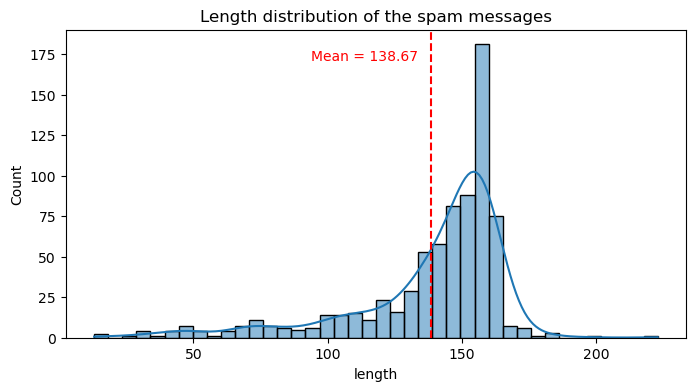

In [13]:
mean_length = df_message_length[df_message_length['type'] == 'spam']['length'].mean()
plt.figure(figsize=(8,4))
sns.histplot(df_message_length[df_message_length['type']=='spam']['length'], kde=True)
plt.axvline(mean_length, color='red', linestyle='--', label='Mean Spam Length')
plt.text(mean_length - 45, plt.ylim()[1]*0.9, f'Mean = {mean_length:.2f}', color='red')
plt.title('Length distribution of the spam messages')
plt.show()

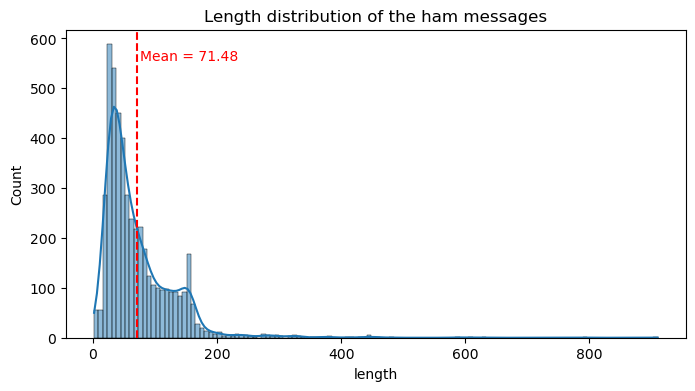

In [14]:
mean_length = df_message_length[df_message_length['type'] == 'ham']['length'].mean()
plt.figure(figsize=(8,4))
sns.histplot(df_message_length[df_message_length['type']=='ham']['length'], kde=True)
plt.axvline(mean_length, color='red', linestyle='--', label='Mean Ham Length')
plt.text(mean_length + 4, plt.ylim()[1]*0.9, f'Mean = {mean_length:.2f}', color='red')
plt.title('Length distribution of the ham messages')
plt.show()

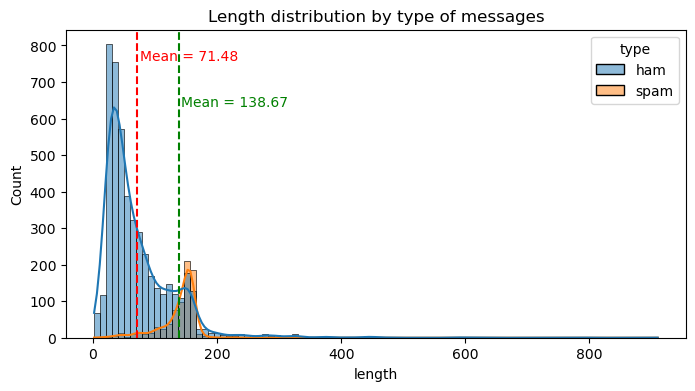

In [15]:
mean_length_ham = df_message_length[df_message_length['type'] == 'ham']['length'].mean()
mean_length_spam = df_message_length[df_message_length['type'] == 'spam']['length'].mean()
plt.figure(figsize=(8,4))
sns.histplot(data = df_message_length, x='length', kde=True, hue='type')
plt.axvline(mean_length_ham, color='red', linestyle='--', label='Mean Spam Length')
plt.axvline(mean_length_spam, color='green', linestyle='--', label='Mean Spam Length')
plt.text(mean_length_ham + 4, plt.ylim()[1]*0.9, f'Mean = {mean_length_ham:.2f}', color='red')
plt.text(mean_length_spam + 4, plt.ylim()[1]*0.75, f'Mean = {mean_length_spam:.2f}', color='green')
plt.title('Length distribution by type of messages')
plt.show()

In [16]:
# The plots suggest that the messages with more lenth tend to be spam, but this is not a rule.
# Let's see if we can find some words that are more common in spam messages than in ham messages.

In [17]:
#This function counts the number of words in each category message
def counter_words(df, msg_type):
    '''
    Parameters --> df: DataFrame / type: str
    Returns --> dictionaty with the words an the frecuency of the words
    '''
    messages = df[df['type'] == msg_type]['message']
    stop_words = set(stopwords.words('english'))
    counted_words = {}
    
    for message in messages:
        tokens = word_tokenize(message.lower())
        for j in tokens:
            if j not in stop_words and j.isalpha():
                counted_words[j] = counted_words.get(j, 0) + 1
                
    return counted_words

spam_words = counter_words(df, 'spam')
ham_words = counter_words(df, 'ham')
spam_words_fr = pd.DataFrame(list(spam_words.items()), columns=['word', 'count'])
ham_words_fr = pd.DataFrame(list(ham_words.items()), columns=['word', 'count'])

In [18]:
#Let's dislay the top ten words more repetetives in each category
print('Top ten words of spam category\n')
print(spam_words_fr.sort_values(by='count', ascending=False).head(10))
print('\nTop ten words of ham category\n')
print(ham_words_fr.sort_values(by='count', ascending=False).head(10))

Top ten words of spam category

       word  count
42     call    346
0      free    219
14      txt    156
86       ur    144
48        u    142
46   mobile    123
10     text    121
248    stop    118
41    claim    113
63    reply    104

Top ten words of ham category

     word  count
20      u    994
227    gt    318
226    lt    316
232   get    302
0      go    251
118    ur    247
16     ok    246
13    got    245
155  know    237
37   like    233


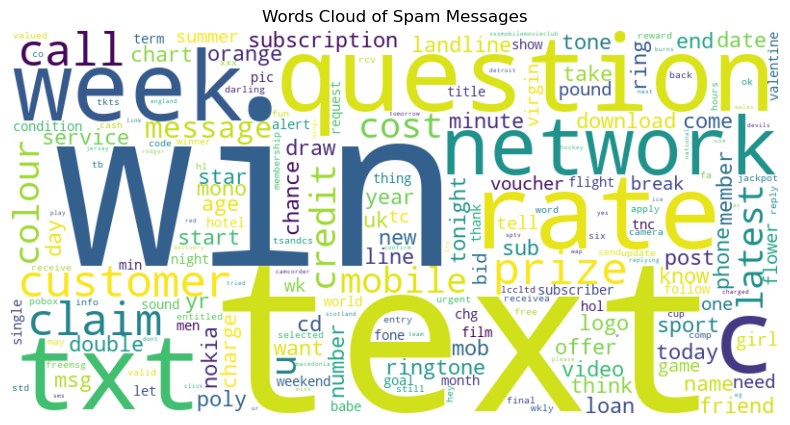

In [19]:
# Let's make a visualization of the most common words in the message category
text_spam = ' '.join(spam_words_fr['word'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_spam)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Cloud of Spam Messages')
plt.show()

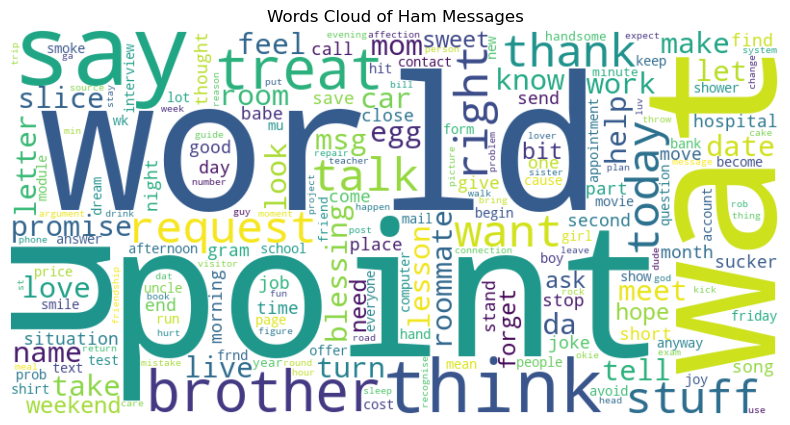

In [20]:
text_ham = ' '.join(ham_words_fr['word'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_ham)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Cloud of Ham Messages')
plt.show()

#### <font color=#A0A0A0>**🧹 Cleaning and Preprocessing**</font>

In [21]:
# Let's make a prediciton of the messages to see which spam or ham

stop_words = set(stopwords.words('english'))

def message_clean(message):
    tokens = word_tokenize(message.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

df['clean_message'] = df['message'].apply(message_clean)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['clean_message'])
y = df['type']

#### <font color=#A0A0A0> **🤖 Modeling and Machine learning**</font>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       966
        spam       0.85      0.94      0.89       149

    accuracy                           0.97      1115
   macro avg       0.92      0.96      0.94      1115
weighted avg       0.97      0.97      0.97      1115



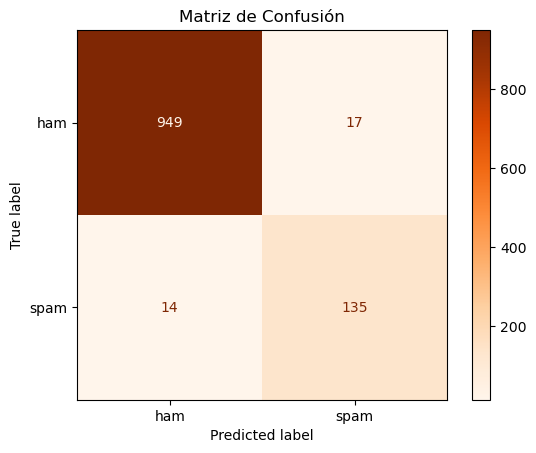

In [25]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
disp.plot(cmap='Oranges', values_format='d')
plt.title("Matriz de Confusión")
plt.show()

In [34]:
# Using GridSearch to test others parameter and get the best model
param_grid = {'alpha' : [0.1, 0.5, 1.0, 1.5, 2.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
print('Best Parameters: ', grid_search.best_params_)
print(classification_report(y_test, y_pred))

Best Parameters:  {'alpha': 2.0}
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       966
        spam       0.89      0.91      0.90       149

    accuracy                           0.97      1115
   macro avg       0.94      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115



#### <font color=#A0A0A0> **🤖 Results and Evaluation**</font>

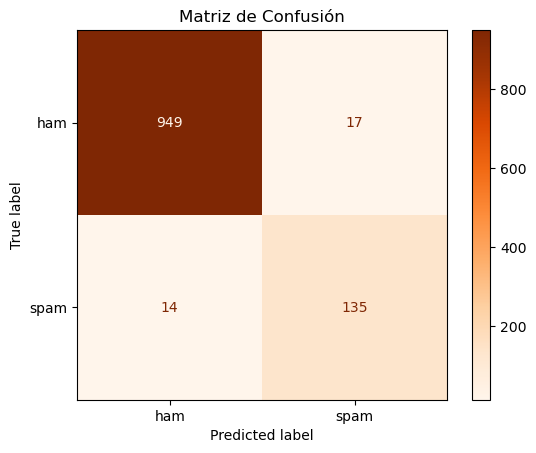

In [35]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
disp.plot(cmap='Oranges', values_format='d')
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
#El modelo logra una precisión del 89% para detectar spam, con un recall del 91%. Esto indica que la mayoría de los mensajes spam fueron 
# correctamente identificados. Sin embargo, se podrían explorar estrategias para reducir los falsos negativos y seguir mejorando la detección.